In [1]:
import numpy as np
import pandas as pd
import os

#print(os.listdir("../input"))

cancer_labs = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv', 
                          dtype=str)

def append_ext(fn):
    return fn+".tif"

cancer_labs["id"]=cancer_labs["id"].apply(append_ext)

print("Cancer image data set count:", cancer_labs.shape[0])

cancer_labs.head()

Cancer image data set count: 220025


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [2]:
class_count = cancer_labs["label"].value_counts()

print("Positive cancer scans:", class_count[1])
print("Positive cancer scans percent:", round(class_count[1] / cancer_labs.shape[0], 2) * 100)
print("Negative cancer scans:", class_count[0])
print("Negative cancer scans percent:", round(class_count[0] / cancer_labs.shape[0], 2) * 100)

Positive cancer scans: 89117
Positive cancer scans percent: 41.0
Negative cancer scans: 130908
Negative cancer scans percent: 59.0


In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(cancer_labs, test_size=0.2, random_state=1017)

print("Cancer image training set rows:", train.shape[0])
print("Cancer image test set rows:", test.shape[0])

Cancer image training set rows: 176020
Cancer image test set rows: 44005


In [4]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 128

image_size = (96, 96)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train, 
    directory='../input/histopathologic-cancer-detection/train/', 
    x_col='id', 
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    has_ext=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test, 
    directory='../input/histopathologic-cancer-detection/train/', 
    x_col='id', 
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    has_ext=False
)

Using TensorFlow backend.


Found 176020 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization

kernel_size = (3,3)
pool_size= (2,2)
dropout = .5

model = Sequential()
model.add(Conv2D(32, kernel_size, input_shape=(96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout))

model.add(Conv2D(64, kernel_size))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout))

model.add(Conv2D(128, kernel_size))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout))

model.add(Conv2D(256, kernel_size))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["binary_accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 45, 45, 64)        256       
__________

In [6]:
model_hist = model.fit_generator(generator=train_generator, 
                                 epochs=25, 
                                 steps_per_epoch=batch_size * 4, 
                                 validation_data=test_generator, 
                                 validation_steps=batch_size)

Epoch 1/25
512/512 [==============================] - 354s 691ms/step - loss: 0.4880 - binary_accuracy: 0.7853 - val_loss: 0.6459 - val_binary_accuracy: 0.6279
Epoch 2/25
512/512 [==============================] - 343s 670ms/step - loss: 0.3865 - binary_accuracy: 0.8326 - val_loss: 0.6051 - val_binary_accuracy: 0.6952
Epoch 3/25
512/512 [==============================] - 335s 654ms/step - loss: 0.3678 - binary_accuracy: 0.8438 - val_loss: 0.5012 - val_binary_accuracy: 0.7840
Epoch 4/25
512/512 [==============================] - 323s 631ms/step - loss: 0.3479 - binary_accuracy: 0.8505 - val_loss: 0.4217 - val_binary_accuracy: 0.8093
Epoch 5/25
512/512 [==============================] - 319s 622ms/step - loss: 0.3418 - binary_accuracy: 0.8546 - val_loss: 0.4382 - val_binary_accuracy: 0.8126
Epoch 6/25
512/512 [==============================] - 318s 622ms/step - loss: 0.3343 - binary_accuracy: 0.8577 - val_loss: 0.4563 - val_binary_accuracy: 0.8019
Epoch 7/25
512/512 [====================

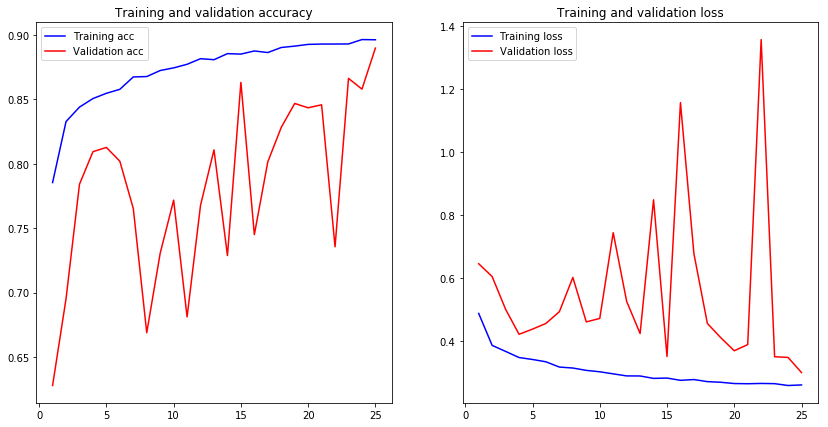

In [7]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history["binary_accuracy"]
    val_acc = history.history["val_binary_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, "b", label="Training acc")
    plt.plot(x, val_acc, "r", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, "b", label="Training loss")
    plt.plot(x, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    
plot_history(history=model_hist)

In [8]:
model_eval = model.evaluate_generator(generator = test_generator, 
                                      steps = np.ceil(len(test_generator.filenames) / batch_size),
                                      verbose = 1)

print("Loss Value:", model_eval[0].round(4))
print("Model Test Accuracy:", model_eval[1].round(4))

344/344 [==============================] - 57s 164ms/step
Loss Value: 0.2962
Model Test Accuracy: 0.8895


In [9]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=test, 
    directory='../input/histopathologic-cancer-detection/train/', 
    x_col='id', 
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    has_ext=False,
    shuffle=False
)

model_probs = model.predict_generator(generator = val_generator, 
                                      steps = np.ceil(len(val_generator.filenames) / batch_size),
                                      verbose = 1)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_generator.classes, model_probs)

print("Model AUC:", auc(fpr_keras, tpr_keras).round(4))

Found 44005 images belonging to 2 classes.
344/344 [==============================] - 57s 165ms/step
Model AUC: 0.9495


In [10]:
from keras.applications.resnet50 import ResNet50

resnet_weights = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

convulution = ResNet50(
    weights= resnet_weights,
    include_top=False,
    input_shape= (96, 96, 3)
)  

model_two = Sequential()
model_two.add(convulution)
model_two.add(Flatten())
model_two.add(Dense(256, use_bias=False))
model_two.add(BatchNormalization())
model_two.add(Activation("relu"))
model_two.add(Dropout(dropout))
model_two.add(Dense(1, activation = "sigmoid"))

convulution.Trainable=True

set_trainable=False
for layer in convulution.layers:
    if layer.name == 'res5a_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
model_two.compile(loss="binary_crossentropy",
                  optimizer="rmsprop",
                  metrics=["binary_accuracy"])        

model_two.summary()

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 3, 3, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               4718592   
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
activation_56 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total para

In [11]:
model_two_hist = model_two.fit_generator(generator=train_generator, 
                                         epochs=25, 
                                         steps_per_epoch=batch_size * 4, 
                                         validation_data=test_generator, 
                                         validation_steps=batch_size)

Epoch 1/25
512/512 [==============================] - 349s 682ms/step - loss: 0.3031 - binary_accuracy: 0.8791 - val_loss: 1.1456 - val_binary_accuracy: 0.8364
Epoch 2/25
512/512 [==============================] - 335s 655ms/step - loss: 0.2456 - binary_accuracy: 0.9040 - val_loss: 0.2995 - val_binary_accuracy: 0.9104
Epoch 3/25
512/512 [==============================] - 335s 655ms/step - loss: 0.2289 - binary_accuracy: 0.9115 - val_loss: 0.2844 - val_binary_accuracy: 0.9022
Epoch 4/25
512/512 [==============================] - 339s 662ms/step - loss: 0.2243 - binary_accuracy: 0.9133 - val_loss: 0.2398 - val_binary_accuracy: 0.9131
Epoch 5/25
512/512 [==============================] - 337s 658ms/step - loss: 0.2096 - binary_accuracy: 0.9199 - val_loss: 0.2778 - val_binary_accuracy: 0.9055
Epoch 6/25
512/512 [==============================] - 338s 660ms/step - loss: 0.2061 - binary_accuracy: 0.9208 - val_loss: 0.2459 - val_binary_accuracy: 0.9180
Epoch 7/25
512/512 [====================

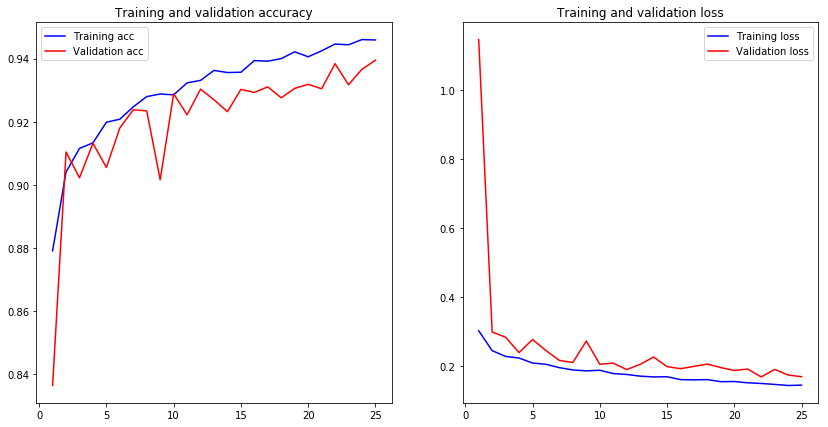

In [12]:
plot_history(history = model_two_hist)

In [13]:
model_two_eval = model_two.evaluate_generator(generator = test_generator, 
                                              steps = np.ceil(len(test_generator.filenames) / batch_size))

print("Loss Value:", model_two_eval[0].round(4))
print("Model Test Accuracy:", model_two_eval[1].round(4))

Loss Value: 0.1779
Model Test Accuracy: 0.9382


In [14]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=test, 
    directory='../input/histopathologic-cancer-detection/train/', 
    x_col='id', 
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    has_ext=False,
    shuffle=False
)

model_two_probs = model_two.predict_generator(generator = val_generator, 
                                              steps = np.ceil(len(val_generator.filenames) / batch_size))

fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_generator.classes, model_two_probs)

print("Model AUC:", auc(fpr_keras, tpr_keras).round(4))

Found 44005 images belonging to 2 classes.
Model AUC: 0.9821
